# Task

## Overview

Thyroid Disease dataset [CSV]
Target –   Class

## Evaluation Criteria

Scoring (10 max):
* EDA: exploration of variables and properties of data with conclusions -  **1**
* Data preprocessing *if   needed* - **2**
    * Handling missing values
    * Dropping unimportant features
    * Data normalizationo
    * Categorical encoding
* Scikit pipeline usage –   **2**
* Metrics and cross-validation chosen as well as reasoning behind – **1**
* Different techniques for handling imbalance data (over\under sampling, class weight) -  **2** 
* Feature engineering e.g. [transformations][1] (nonlinear) -  **1**
* Feature importance and [hyperparameters][2] tuning –   **1**

Models: Logistic Regression w\wo regularization; K-nearest neighbo

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer
[2]: https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers

In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt

import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
from functools import partial

from sklearn.model_selection import cross_validate, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, make_scorer, f1_score


# Data Set

## [Thyroid Disease Data Set](http://archive.ics.uci.edu/ml/datasets/thyroid+disease)

### Abstract: 

10 separate databases from Garavan Institute
This data set if one of the several databases about Thyroid avalaible at the UCI repository. 

The task is to detect is a given patient is normal (1) or suffers from hyperthyroidism (2) or hypothyroidism (3) .

### Data Set Information:

 From Garavan Institute
A Thyroid database suited for training ANNs

* 3 classes
* 3772 training instances, 3428 testing instances
* Includes cost data (donated by Peter Turney)

#### columns

* age - **numeric**
* sex - **{0,1}**
* on_thyroxine - **{0,1}**
* query_on_thyroxine - **{0,1}**
* on_antithyroid_medication - **{0,1}**
* sick - **{0,1}**
* pregnant - **{0,1}**
* thyroid_surgery - **{0,1}**
* I131_treatment - **{0,1}**
* query_hypothyroid - **{0,1}**
* query_hyperthyroid - **{0,1}**
* lithium - **{0,1}**
* goitre - **{0,1}**
* tumor - **{0,1}**
* hypopituitary - **{0,1}**
* psych - **{0,1}**
* TSH_measured - **{0,1}**
* TSH - **numeric**
* T3_measured - **{0,1}**
* T3 - **numeric**
* TT4_measured - **{0,1}**
* TT4 - **numeric**
* T4U_measured - **{0,1}**
* T4U - **numeric**
* FTI_measured - **{0,1}**
* FTI - **numeric**
* TBG_measured - **{0,1}**
* TBG - **numeric**
* referral_source - - **{1,2,3,4,5}**
* **Class** - **{1,2,3}**

In [3]:
TARGET_COLUMN = 'Class'

# Preprocessing

In [4]:
data = pd.read_csv(os.path.join('data', 'dataset_57_hypothyroid.csv'))
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [5]:
data[TARGET_COLUMN].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

Представителей класса 'secondary_hypothyroid' всего два. Исключим их из анализа.

In [6]:
def filter_target_values(x):
    return x[x[TARGET_COLUMN] != 'secondary_hypothyroid']

target_filter = FunctionTransformer(filter_target_values, validate=False)
data = target_filter.transform(data)

In [7]:
encoder = LabelEncoder()
data[TARGET_COLUMN] = encoder.fit_transform(data[TARGET_COLUMN])
class_mapping = dict(enumerate(encoder.classes_))

In [8]:
encoder.classes_

array(['compensated_hypothyroid', 'negative', 'primary_hypothyroid'],
      dtype=object)

## Drop duplicates

In [9]:
data.shape

(3770, 30)

In [10]:
def drop_duplicate_values(x):
    return x.drop_duplicates()

data = FunctionTransformer(drop_duplicate_values, validate=False).transform(data)
data.shape

(3709, 30)

## Replace Values

Заменим идентификаторы на соответствующие численные значения.

In [11]:
def replace_values(x):
    return x.replace(to_replace={'f':0,'t':1, 'y':1, 'n':0, '?': np.nan, 'M':0, 'F':1})

data = FunctionTransformer(replace_values, validate=False).transform(data)
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,1,0,0,0,0,0,0,0,0,...,1,125,1,1.14,1,109,0,NaN,SVHC,1
1,23,1,0,0,0,0,0,0,0,0,...,1,102,0,NaN,0,NaN,0,NaN,other,1
2,46,0,0,0,0,0,0,0,0,0,...,1,109,1,0.91,1,120,0,NaN,other,1
3,70,1,1,0,0,0,0,0,0,0,...,1,175,0,NaN,0,NaN,0,NaN,other,1
4,70,1,0,0,0,0,0,0,0,0,...,1,61,1,0.87,1,70,0,NaN,SVI,1


In [12]:
data['referral_source'].value_counts()

other    2138
SVI      1034
SVHC      386
STMW      112
SVHD       39
Name: referral_source, dtype: int64

In [13]:
data['referral_source'] = encoder.fit_transform(data['referral_source'])
referral_source_mapping = dict(enumerate(encoder.classes_))
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,1,0,0,0,0,0,0,0,0,...,1,125,1,1.14,1,109,0,NaN,1,1
1,23,1,0,0,0,0,0,0,0,0,...,1,102,0,NaN,0,NaN,0,NaN,4,1
2,46,0,0,0,0,0,0,0,0,0,...,1,109,1,0.91,1,120,0,NaN,4,1
3,70,1,1,0,0,0,0,0,0,0,...,1,175,0,NaN,0,NaN,0,NaN,4,1
4,70,1,0,0,0,0,0,0,0,0,...,1,61,1,0.87,1,70,0,NaN,3,1


## Manage types

In [14]:
set(data.dtypes)

{dtype('int64'), dtype('O')}

Приведём даные к числовому типу, игнорируя ошибки конвертации (так как в данных всё ещё содержатся nan)

In [15]:
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
categorial_columns = list(set(data.columns) - set(numeric_columns))

In [16]:
def convert_types(x):
    _x = x
    _x[numeric_columns] = _x[numeric_columns].astype('float64', errors='ignore')
    _x[categorial_columns] = _x[categorial_columns].astype('category', errors='ignore')
    return _x

types_converter = FunctionTransformer(convert_types, validate=False)
data = types_converter.transform(data)

set(data.dtypes)

{CategoricalDtype(categories=[0], ordered=False),
 CategoricalDtype(categories=[0, 1, 2], ordered=False),
 CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=False),
 CategoricalDtype(categories=[0, 1], ordered=False),
 CategoricalDtype(categories=[], ordered=False),
 dtype('float64')}

In [17]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3708.000000,3400.000000,3000.000000,3538.000000,3383.000000,3385.000000
mean,51.864887,5.089456,2.013613,108.369927,0.995020,110.497400
std,20.127992,24.532057,0.827667,35.571119,0.195506,33.078955
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


In [18]:
# pandas_profiling.ProfileReport(data)

Из предварительного анализа видно, что в данных содержатся пропуски, на их количество не критично (кроме колонки 'TBG', в которой совсем отсутствует информация). 

Пропуски, можно восстановить (заменив их, например, одной из оценок цетральной изменчивости с помощью SimpleImputer). Оптимальный Imputer подберём в процессе CV.

Исключим колонки 'TBG_measured', 'TBG', так как они не содержат информации.

In [19]:
def selected_columns(X):
    return X.drop(columns=['TBG_measured', 'TBG'])

dropper = FunctionTransformer(selected_columns, validate=False)
data = dropper.transform(data)

## Check outliers

In [20]:
def get_outlier_precetage(x, col):
    _data = x.dropna(subset=[col])
    new_shape = _data[col].loc[np.abs(stats.zscore(_data[col])) < 3].shape[0]
    old_shape = _data[col].shape[0]
    return round(100 * (1 - (new_shape / old_shape)), 2)


def check_outliers(x, cols):
    return pd.Series({col: get_outlier_precetage(x, col) for col in cols})

sum(check_outliers(data, numeric_columns))

7.59

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


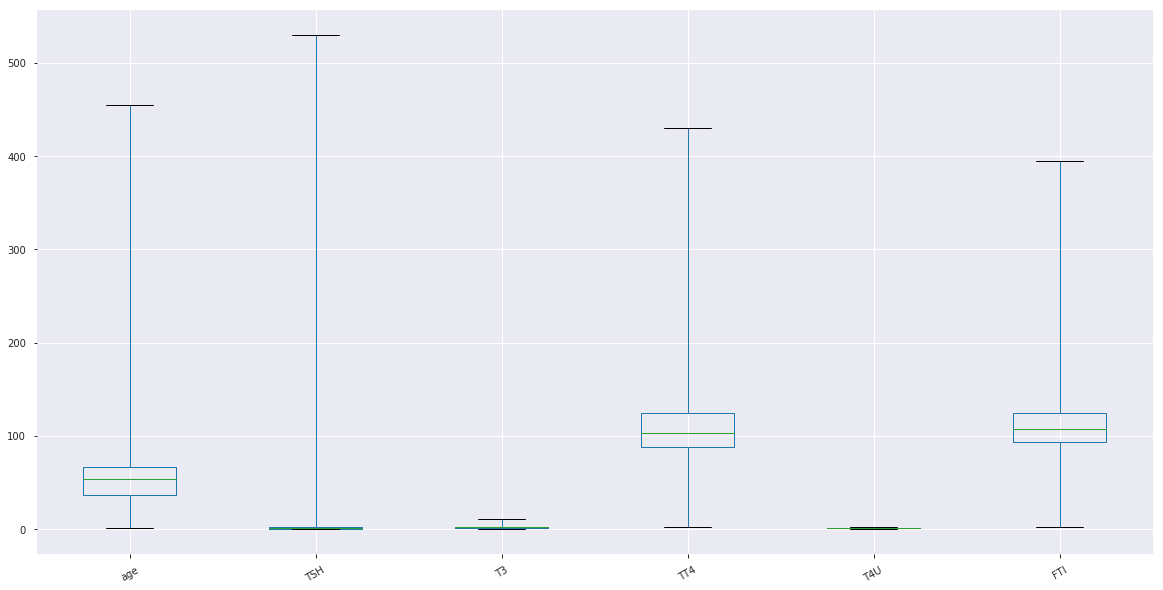

In [21]:
data[numeric_columns].boxplot(whis='range', figsize=(20,10), rot=30)

Количество выбросов небольшое, однако по величине выбросы достаточно велики. Заменим их на np.nan, для полседующей замены импутером.

In [22]:
data.isna().sum()

age                            1
sex                          149
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                          309
T3_measured                    0
T3                           709
TT4_measured                   0
TT4                          171
T4U_measured                   0
T4U                          326
FTI_measured                   0
FTI                          324
referral_source                0
Class                          0
dtype: int64

In [23]:
def replace_outliers(data, columns=None, fill_value=np.nan):
    columns = columns or list(data.columns)
    result = data
    for col in columns:
        clear_data = data[[col]].dropna()
        clear_data[col + '_'] = np.abs(stats.zscore(clear_data)) < 3
        result = pd.merge(result, clear_data[[col + '_']], how='left', left_index=True, right_index=True)
        result.loc[result[col + '_'] == False, col] = fill_value
        result = result.drop(columns=[col + '_'])
    return result

outliers_replacer = FunctionTransformer(partial(replace_outliers, columns=numeric_columns), validate=False)
data = outliers_replacer.transform(data)

In [24]:
check_outliers(data, numeric_columns)

FTI    1.57
T3     0.81
T4U    1.30
TSH    2.41
TT4    1.20
age    0.00
dtype: float64

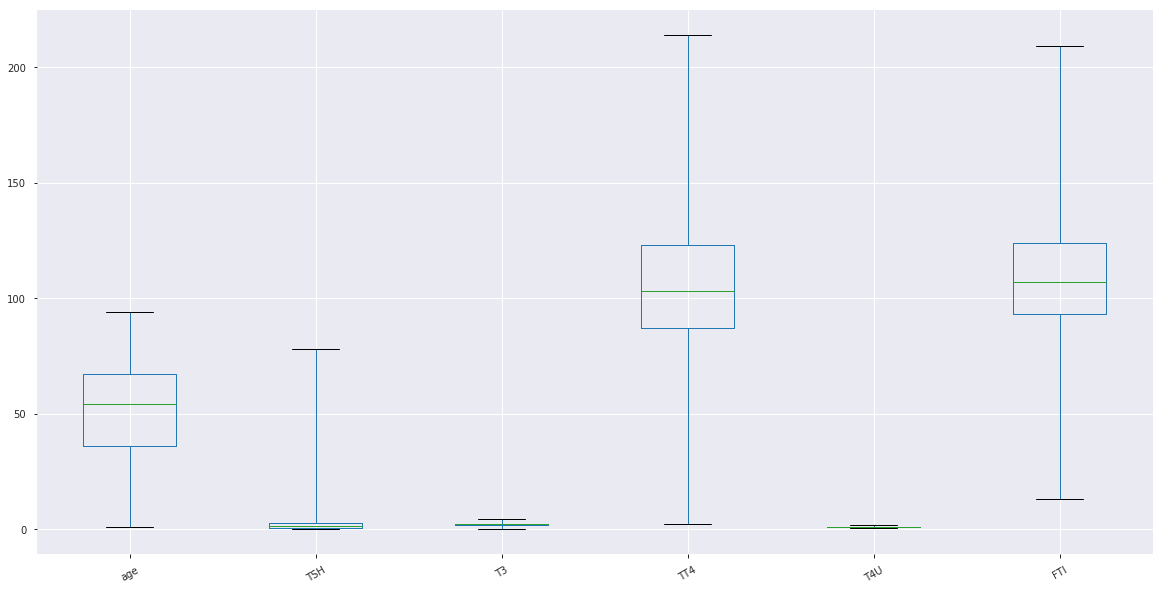

In [25]:
data[numeric_columns].boxplot(whis='range', figsize=(20,10), rot=30)

Одной процедуры исключения выбросов оказалось недостаточно. Будем повторять её до тех пор, пока выбросов не останется.

In [26]:
# step = 1
# while sum(check_outliers(data, numeric_columns)) > 0.1:
#     data = outliers_replacer.transform(data)
#     step += 1
#     print('step: {}'.format(step))

In [27]:
def cycle_replace_outliers(x, num_iter=None):
    if num_iter:
        for _ in range(num_iter):
            x = outliers_replacer.transform(x)
        return x

    while sum(check_outliers(x, numeric_columns)) > 0.1:
        x = outliers_replacer.transform(x)
    return x

cycle_outliers_replacer = FunctionTransformer(cycle_replace_outliers, validate=False)
data = cycle_outliers_replacer.transform(data)
data.shape

(3709, 28)

In [28]:
pd.Series({col: get_outlier_precetage(data, col) for col in numeric_columns})

FTI    0.0
T3     0.0
T4U    0.0
TSH    0.0
TT4    0.0
age    0.0
dtype: float64

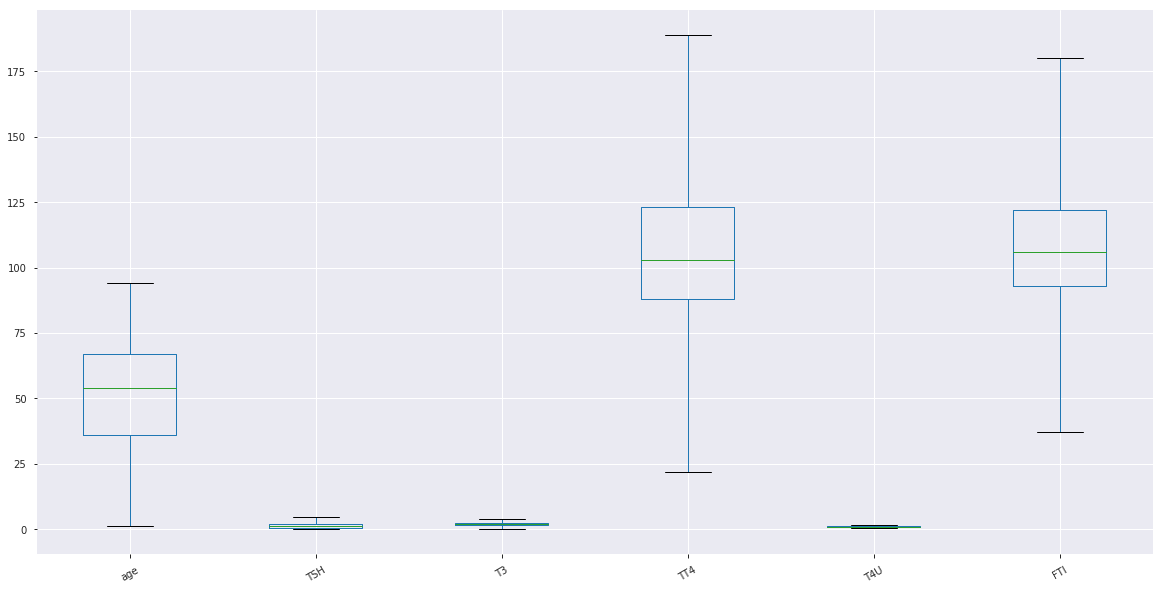

In [29]:
data[numeric_columns].boxplot(whis='range', figsize=(20,10), rot=30)

In [30]:
data.isna().sum()

age                            2
sex                          149
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                          782
T3_measured                    0
T3                           798
TT4_measured                   0
TT4                          299
T4U_measured                   0
T4U                          460
FTI_measured                   0
FTI                          480
referral_source                0
Class                          0
dtype: int64

In [31]:
set(data.dtypes)

{CategoricalDtype(categories=[0, 1, 2], ordered=False),
 CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=False),
 CategoricalDtype(categories=[0, 1], ordered=False),
 dtype('float64')}

Избавившись от выбросов, немного увеличили количество пропуков в данных. Необходимо теперь эти пропуски заполнить

In [32]:
X = data.drop(columns=[TARGET_COLUMN])
Y = data[[TARGET_COLUMN]]

In [33]:
# Age - “mean”, так как пропущен всего один экземпляр.
# Sex - “most_frequent”, чтобы не получились значения отличные от {0,1}
# TSH, T3, TT4, T4U, FTI - “mean” or  “median”

In [34]:
features_most_frequent = ['sex', 'age']
features_mean_or_median = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
other_features = list(set(X.columns) - set(features_most_frequent + features_mean_or_median)) 

In [35]:
imputer = ColumnTransformer(transformers=[
    ('imputer_most_frequent', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), features_most_frequent),
    ('imputer_mean_or_median', SimpleImputer(missing_values=np.nan, strategy='median'), features_mean_or_median),
    ('imputer_other', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), other_features)
])

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [37]:
data.shape

(3709, 28)

In [38]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape 

((2967, 27), (742, 27), (2967, 1), (742, 1))

In [39]:
imputer.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('imputer_most_frequent',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               missing_values=nan,
                                               strategy='most_frequent',
                                               verbose=0),
                                 ['sex', 'age']),
                                ('imputer_mean_or_median',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               mi...
                                               strategy='most_frequent',
                                               verbose=0),
                                 ['FTI_measured'

In [40]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [41]:
X_train.shape, X_test.shape

((2967, 27), (742, 27))

In [42]:
columns = features_most_frequent + features_mean_or_median + other_features
X_test = pd.DataFrame(X_test, columns=columns)
X_train = pd.DataFrame(X_train, columns = columns)

In [43]:
# X_train['age'].value_counts()

In [44]:
#pandas_profiling.ProfileReport(X_train)
X_train.describe()

,sex,age,TSH,T3,TT4,T4U,FTI,FTI_measured,T4U_measured,hypopituitary,...,tumor,TT4_measured,query_hyperthyroid,psych,query_on_thyroxine,query_hypothyroid,referral_source,TSH_measured,goitre,on_thyroxine
count,2967.0,2967.0,2967.0,2967.0,2967.0,2967.00,2967.0,2967,2967,2967,...,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967
unique,2.0,92.0,143.0,40.0,164.0,90.00,139.0,2,2,2,...,2,2,2,2,2,2,5,2,2,2
top,1.0,59.0,1.1,2.0,103.0,0.97,106.0,1,1,0,...,0,1,0,0,0,0,4,1,0,0
freq,2054.0,78.0,695.0,827.0,277.0,433.00,431.0,2719,2718,2966,...,2888,2842,2775,2832,2927,2773,1686,2726,2940,2603


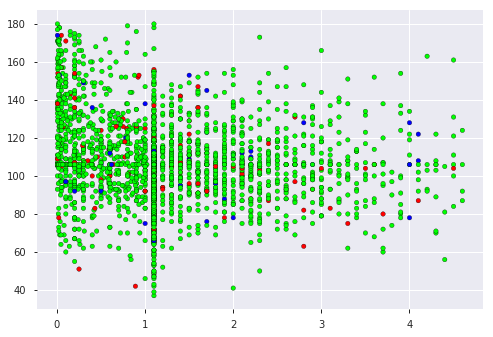

In [45]:
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

_data = pd.concat([X_train, Y_train], axis=1)

plt.scatter(_data['TSH'], _data['FTI'], c=_data[TARGET_COLUMN], cmap=cmap_bold, edgecolor='k', s=20)



In [46]:
standart_scaler = StandardScaler()

In [47]:
standart_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
train = standart_scaler.transform(X_train)
test = standart_scaler.transform(X_test)

## Data reader

выделим весь детерменирвоанный препроцессинг в отдельную функцию

In [49]:
def data_reader():
    data = pd.read_csv(os.path.join('data', 'dataset_57_hypothyroid.csv'))

    data = FunctionTransformer(filter_target_values, validate=False).transform(data)
    data[TARGET_COLUMN] = LabelEncoder().fit_transform(data[TARGET_COLUMN])
    data['referral_source'] = LabelEncoder().fit_transform(data['referral_source'])

    data = Pipeline(steps=[
        ('duplicate_dropper', FunctionTransformer(drop_duplicate_values, validate=False)),
        ('replacer', FunctionTransformer(replace_values, validate=False)),
        ('types_converter', FunctionTransformer(convert_types, validate=False)),        
        ('dropper', FunctionTransformer(selected_columns, validate=False))
    ]).transform(data)
    return data.drop(columns=[TARGET_COLUMN]), data[[TARGET_COLUMN]]

# Base line

In [50]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, Y_train.values.ravel())
print("model score: %.3f" % neigh.score(X_test, Y_test))

model score: 0.923


In [51]:
x,y = data_reader()
x.shape, y.shape

((3709, 27), (3709, 1))

In [52]:
model = Pipeline(steps=[
        ('cycle_outlier_replacer', FunctionTransformer(cycle_replace_outliers, validate=False)),
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('clsfier', KNeighborsClassifier())])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model.fit(x_train, y_train.values.ravel())
print("model score: %.3f" % model.score(x_test, y_test))

model score: 0.927


# CV

In [53]:
polynomial_features = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [54]:
import itertools
def param_converter(params, names):
    return dict(zip(params, names))

def model_parametrs_generator(param_sets):
    yield from map(lambda x: dict(zip(param_sets.keys(), x)), list(itertools.product(*param_sets.values())))
    
def get_outlier_replacer(num_iterations):
    return FunctionTransformer(partial(cycle_replace_outliers, num_iter=num_iterations), validate=False)

## Preprocessing CV

Для начала, определим оптимальные гипер параметры перпроцессинга.

In [55]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import Pipeline

In [56]:
smt = SMOTE(random_state=42)
cc = ClusterCentroids(random_state=42)

model = Pipeline(steps=[
        ('cycle_outlier_replacer', FunctionTransformer(cycle_replace_outliers, validate=False)),
        ('imputer', imputer),
        ('scaler', StandardScaler()),
        ('sampler', smt),
        ('polynomial_features', polynomial_features),
        ('clsfier', KNeighborsClassifier())])

standart_scaler = StandardScaler()
robust_scaler = RobustScaler()

scoring = make_scorer(f1_score, average='weighted')
parameters = {
    'scaler': [standart_scaler, robust_scaler],
    'imputer__imputer_mean_or_median__strategy': ['mean', 'median'],
    'polynomial_features__degree': [1, 2, 3], # 1 to check are polynomial features really needed. (performs for LogisticRegression)
    'cycle_outlier_replacer': [get_outlier_replacer(num_it) for num_it in [1, 2, 3]] + [None],
    'sampler': [smt, cc, None], # over\under sampling
    'clsfier': [KNeighborsClassifier(), LogisticRegression()]
}

model = GridSearchCV(model, parameters, scoring=scoring, cv=TimeSeriesSplit(n_splits=5), verbose=1, n_jobs=8)

In [57]:
x,y = data_reader()
x.shape, y.shape

((3709, 27), (3709, 1))

In [58]:
model.fit(x, y.values.ravel())

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 14.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 24.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 48.4min
[Parallel(n_jobs=8)]: Done 1440 out of 1440 | elapsed: 60.5min finished
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cycle_outlier_replacer',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<function cycle_replace_outliers at 0x7f735117f048>,
                                                            inv_kw_args=None,
                                                            inverse_func=None,
                                                            kw_args=None,
                                                            pass_y='deprecated',
                                                            validate=...
                                     ClusterCentroids(estimator=None, n_jobs=1,
                                 

In [59]:
model.best_score_

0.9808421579706016

In [60]:
model.best_estimator_

Pipeline(memory=None,
         steps=[('cycle_outlier_replacer', None),
                ('imputer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('imputer_most_frequent',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['sex', 'age']),
                                                 ('imputer_mean_or...
             

In [61]:
model.best_estimator_.steps[0]

('cycle_outlier_replacer', None)

In [62]:
model.best_estimator_.steps[1][1].transformers[1][1].strategy

'median'

In [63]:
model.best_estimator_.steps[2]

('scaler',
 RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
              with_scaling=True))

In [64]:
model.best_estimator_.steps[3]

('sampler', None)

In [65]:
model.best_estimator_.steps[4]

('polynomial_features',
 PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                    order='C'))

В результате перекрёсной проверки гипер параметров препроцессинга, можно сделать вывод о том, что вместо процедуры "вычищения" выбросов, лучше воспользоватся робастным скейлером. 

Пропуске в numeric columns лучше заменять значением медианы, а от сэмплирования лучше отказаться.

Переделаем пайплайн с учётом полученной информации. В качестве мтерики качетсва (уже) используется f1 скор (учитывающий и точность и полноту классификации). Рассматривается взвешенная версия этой метрики, так как в датасете наблюдается значительный дисбаланс классов.

## Model CV

In [66]:
pipeline = Pipeline(steps=[
        ('imputer', imputer),
        ('scaler', robust_scaler),
        ('polynomial_features', polynomial_features),
        ('clsfier', KNeighborsClassifier())])

И проверим гипер параметры классификационных моделей.

In [67]:
knn_param_sets = {'n_neighbors': range(1,15), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree']}
knn_models = [KNeighborsClassifier(**x) for x in model_parametrs_generator(knn_param_sets)]


logreg_param_sets = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'saga'], 'l1_ratio': [0.5]}
logreg_models = [LogisticRegression(**x) for x in model_parametrs_generator(logreg_param_sets)]

lorreg_solvers = {
    'newton-cg' : ['l2', 'none'], 
    'lbfgs': ['l2', 'none'], 
    'saga': ['l1', 'l2', 'elasticnet', 'none']
}

logreg_models = list(filter(lambda x: x.penalty in lorreg_solvers[x.solver],logreg_models))

models = knn_models + logreg_models

In [68]:
parameters = {'clsfier': models}

final_model = GridSearchCV(pipeline, parameters, scoring=scoring, cv=TimeSeriesSplit(n_splits=5), verbose=1, n_jobs=6)

In [69]:
x,y = data_reader()
final_model.fit(x, y.values.ravel())

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   59.8s
[Parallel(n_jobs=6)]: Done 320 out of 320 | elapsed:  2.8min finished
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceW

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('imputer_most_frequent',
                                                                         SimpleImputer(add_indicator=False,
                                                                                       copy=True,
                                                                                       fill_value=None,
                                                                         

In [70]:
final_model.best_estimator_

Pipeline(memory=None,
         steps=[('imputer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('imputer_most_frequent',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['sex', 'age']),
                                                 ('imputer_mean_or_median',
                                                  SimpleI

In [71]:
final_model.best_score_

0.9809230251373878

Лучшей моделью оказалась логистическая регрессия без регуляризации.

## Nested CV

In [72]:
cross_val_score(final_model.best_estimator_, x, y.values.ravel(), cv=TimeSeriesSplit(n_splits=5))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. 

array([0.9789644 , 0.98220065, 0.9789644 , 0.98867314, 0.9789644 ])

## confusion matrix

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

In [74]:
for _ in range(5):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
    print(confusion_matrix(y_test, final_model.predict(x_test)))
    print('---------------------------------------------------------------')

[[  59   13    0]
 [   1 1371    0]
 [   0    2   38]]
---------------------------------------------------------------
[[  62   10    1]
 [   1 1380    0]
 [   0    1   29]]
---------------------------------------------------------------
[[  56   13    0]
 [   4 1380    0]
 [   1    0   30]]
---------------------------------------------------------------
[[  73    7    1]
 [   0 1363    0]
 [   1    3   36]]
---------------------------------------------------------------
[[  75    6    1]
 [   2 1363    0]
 [   1    1   35]]
---------------------------------------------------------------


## classification report

In [75]:
for _ in range(5):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
    print(classification_report(y_test, final_model.predict(x_test)))
    print('---------------------------------------------------------------')

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        86
           1       0.99      1.00      1.00      1355
           2       1.00      0.93      0.96        43

    accuracy                           0.99      1484
   macro avg       0.99      0.94      0.96      1484
weighted avg       0.99      0.99      0.99      1484

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        73
           1       0.99      1.00      0.99      1380
           2       1.00      0.97      0.98        31

    accuracy                           0.99      1484
   macro avg       0.97      0.94      0.95      1484
weighted avg       0.99      0.99      0.99      1484

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        86
 

## Feature importance

In [76]:
logreg_model = final_model.best_estimator_.steps[3][1]
logreg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.5,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [77]:
coef = pd.DataFrame(np.abs(logreg_model.coef_)).T

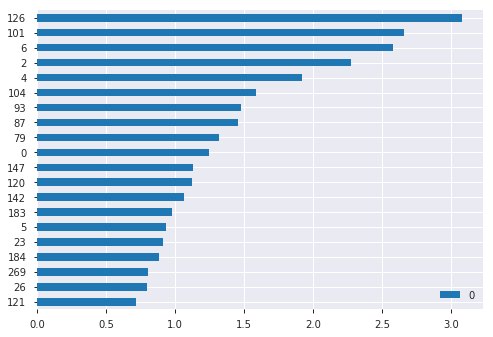

In [78]:
coef[[0]].sort_values(0).tail(20).plot.barh()

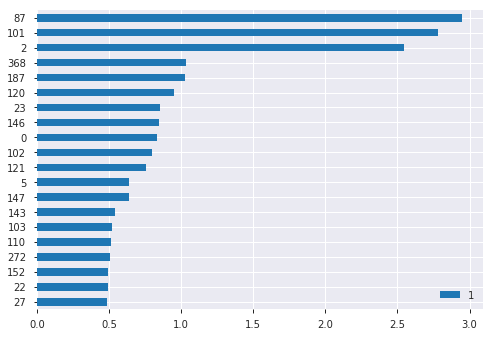

In [79]:
coef[[1]].sort_values(1).tail(20).plot.barh()

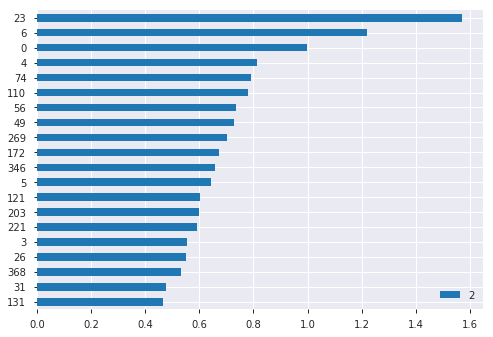

In [80]:
coef[[2]].sort_values(2).tail(20).plot.barh()